<B>Preface</B><BR>
Visualizations are an important product of some data science work.  This lab is based on the hurricane tracker nifty assignment described here:  http://nifty.stanford.edu/2018/ventura-hurricane-tracker/nifty-hurricanes.html This assignment is a chance for you to hone your visualization skills and practice using matplotlib, pandas, and numpy.  This assignment is also an opportunity to practice your web scraping skills.  
<P>
<B>Part 1: Visualizing the Path of a Hurricane</B><BR>
You will need to download some files http://nifty.stanford.edu/2018/ventura-hurricane-tracker/StarterFiles.zip  and put them on your drive, ideally within the folder where you are storing your other files for this class. At a miniumum, you will need the picture of the atlantic basin, and the data for at least one hurricane.  I used Irma. Your goal is a picture as shown in Part 1.png.<BR>
 Now you are ready to add your first block of code.  This block of code should <ol><li>Mount your drive</li><li>Import necessary libraries.</li><li>Read the data into a pandas data frame</li><li>Setup the graph.</li><li>Display the picture.</li><BR> Your goal is a picture as shown in Part 1.png.<p>
 <img src="Part1.PNG"><BR>
 Part1.PNG
 

 
 



Please enter the name of a hurricane: ike
Searching...
Found [3] hurricanes with that name
Please enter the year of the desired hurricane: 2008
Rendering...


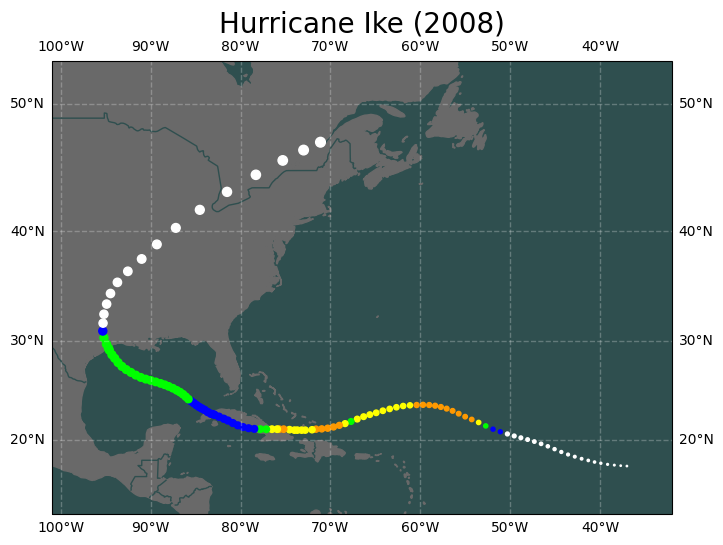

Done! [1634.0ms]


In [ ]:
#------------------------------------------------------------------------------#
# This code was written for lab 5 of CST 475,          © Justin Boehnen 2022             
# taught at Oregon Tech by Prof. Cecily Heiner
#------------------------------------------------------------------------------#
#!pip install cartopy
#!pip uninstall shapely
#!pip install shapely --no-binary shapely
from google.colab import drive
from google.colab import output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, 
                                LatitudeLocator, LongitudeLocator)
import cartopy.feature as cfeature
import requests
from bs4 import BeautifulSoup as soup
import time
import math
import warnings
warnings.filterwarnings("ignore")

dir = "/content/gdrive/My Drive/Colab Notebooks/lab6/{}"
tab_dir = "http://ibtracs.unca.edu/index.php?name=Letter-{}"
hur_dir = "http://ibtracs.unca.edu/{}"

#------------------------------------------------------------------------------#
# Function:   hurricane_category_to_color
# Purpose:    This function converts a list of floats representing wind speed
#             into a list of matplotlib compatible colors representing
#             different hurricane categories as defined by the Saffir-Simpson 
#             hurricane wind scale
# Args:       wind      list of floats representing wind speed (kt)
# Return:     color     list of matplotlib compatible colors
#------------------------------------------------------------------------------#
def hurricane_category_to_color(wind):
  color = []
  for w in wind:
    if w < 64:
      color.append("#ffffff") #not hurricane
    elif w < 83:
      color.append("#0000ff") #cat 1
    elif w < 96:
      color.append("#00ff00") #cat 2
    elif w < 113:
      color.append("#ffff00") #cat 3
    elif w < 137:
      color.append("#ff9900") #cat 4
    else:
      color.append("#ff0000") #cat 52
  return color

# Function to meet requirements of part 1 of lab 5
def part1():
  bkg = plt.imread(dir.format("atlantic-basin.png"))
  fig, ax = plt.subplots()
  ax.imshow(bkg, extent=[-90, -17.66, 0, 45])
  hurricane_csv = open(dir.format("irma.csv"))
  dataframe=pd.read_csv(hurricane_csv)
  rawx = dataframe.Lon
  rawy = dataframe.Lat
  plt.scatter(rawx, rawy, s=5)
  plt.show()

def run_full_demo():
  print("---------- Part 1 ----------")
  part1()
  print("---------- Part 2 ----------")
  part2()
  print("---------- Part 3 ----------")
  part3() 

drive.mount('/content/gdrive', force_remount=True)
output.clear()

#run_full_demo()

#part1()
#part2()
part3()

drive.flush_and_unmount()

## Hurricane Suggestions ##
#   Irma    2017      Visually appealing and contains all hurricane categories
#   Katrina 2005      Category 5 hurricane that caused $125 billion in damages 
#                     and decimated many parts of New Orleans.
#   Grace   1958      Strongest recorded wind speeds of any hurricane
#   John    1994      Furthest travelling hurricane in recorded history
#   Olivia  1996      Shows a different area of the world
#   Justin  NA        Demonstrates functionality when a year is not required to 
#                     find the desired hurricane. Also the coolest sounding 
#                     hurricane.

 <B>Part 2: Use Color to show windspeed.</B><BR>
Modify your graph from Part 1 to show the windspeed.  <ul>
<li>Red for Category 5</li>
<li>Orange for Category 4</li>
<li>Yellow for Category 3</li>
<li>Green for Category 2</li>
<li>Blue for Category 1</li>
<li>White if not hurricane strength</li>


In [ ]:
# Function to meet requirements of part 2 of lab 5
def part2():
  bkg = plt.imread(dir.format("atlantic-basin.png"))
  fig, ax = plt.subplots()
  ax.imshow(bkg, extent=[-90, -17.66, 0, 45])
  hurricane_csv = open(dir.format("irma.csv"))
  dataframe=pd.read_csv(hurricane_csv)
  rawx = dataframe.Lon
  rawy = dataframe.Lat
  wind = dataframe.Wind
  color = hurricane_category_to_color(list(wind))
  plt.scatter(rawx, rawy, c=color, s=5)
  plt.show()
  plt.savefig("test.png", dpi = (200))

 <B>Part 3: User Requested Storm</B><BR>
  Prompt the user to enter the name of the storma and the year, then scrape the web using this website to find the storm data.  Then display for the storm that the user is inquiring about.  http://ibtracs.unca.edu/index.php?name=Letter-I


In [ ]:
HAS_ABORTED = False
RENDER_START_TIME = 0
H_YEAR = 0

#------------------------------------------------------------------------------#
# Function:   dist_travelled
# Purpose:    This function will calculate the distance travelled between
#             point [lat[start], lon[start]] and point [lat[end], lon[end]]
# Args:       lat       list of all latitude (x) coords
#             lon       list of all longitude (y) coords
#             start     index of starting [lat, lon] point
#             end       index of ending [lat, lon] point
# Return:     (float) distance between start and end point
#------------------------------------------------------------------------------#
def dist_travelled(lat, lon, start, end):
  dist = 0.0
  prev = {'x': lat[start], 'y': lon[start]}
  for i in range(end-start):
    dist += ((lat[i] - prev['x'])**2 + (lon[i] - prev['y'])**2)**0.5
    prev = {'x': lat[i], 'y': lon[i]}
  return dist

#------------------------------------------------------------------------------#
# Function:   large_to_small
# Purpose:    This function creates a list of floats (n=number of elements in 
#             lat). The list of floats is a smooth gradient from sml to lrg,
#             where each float corresponds to a point of the hurricane and it's
#             percent distance through the entire hurricane travel distance.
#             When supplied to the plot size or color args this list will
#             create a visually smooth gradient of color or size change through
#             entire path of the hurricane.
# Args:       lat       list of all latitude (x) coords
#             lon       list of all longitude (y) coords
#             lrg       value of large gradient value
#             sml       value of small gradient value
# Return:     list of floats in a smooth gradient
#------------------------------------------------------------------------------#
def large_to_small(lat, lon, lrg, sml):
  sizes = []
  tot_dist = dist_travelled(lat, lon, 0, len(lat))
  for i, x in enumerate(range(len(lat))):
    sizes.append(dist_travelled(lat,lon,0,i)/tot_dist)
  return list(map(lambda x: (sml + ((x / 1) * (lrg - sml))), sizes))

#------------------------------------------------------------------------------#
# Function:   sanitize_wind
# Purpose:    This function extracts the desired wind value from raw wind table 
#             data and replaces missing data with a wind value of 0.0
# Args:       content   raw wind table data (single element not list)
# Return:     float representing wind speed
#------------------------------------------------------------------------------#
def sanitize_wind(content):
  if isinstance(content, list):       # if content is a list throw away garbage
    if len(content) > 1:
      content = content[1].contents[0].contents[0]
    else:
      content = content[0][1:]
  if content.isnumeric():             # if content is a number return it
    content = float(content)
  else:
    content = 0.0                     # else default to 0.0 and then return
  return content

#------------------------------------------------------------------------------#
# Function:   scrape_data
# Purpose:    This function scrapes the web for data pertaining to hurricane 
#             h_name. Function will aquire hurricane year if h_name is 
#             ambiguous.
# Args:       h_name    name of desired hurricane
# Return:     lat       list of floats representing latitude (x) coord
#             lon       list of floats representing longitude (y) coord
#             win       list of floats representing wind speed
#------------------------------------------------------------------------------#
def scrape_data(h_name):
  global HAS_ABORTED
  global RENDER_START_TIME
  global H_YEAR

  
  if h_name.isalpha() is False:         # check if user input is alphabetical
    print("Name contains invalid characters, aborting.")
    HAS_ABORTED = True
  else:
    print("Searching...")

    # load letter-specific page (first letter of h_name) 
    # and find list of all hurricanes with that name
    letter_url = tab_dir.format(h_name[0].upper())
    letter_page = requests.get(letter_url)
    letter_soup = soup(letter_page.text, 'lxml')
    h_table = letter_soup.find_all('table')[1]
    h_td = h_table.find_next('td', text=' {}'.format(h_name.upper()))

    if h_td == None:                    # check if user input finds a match
      print("No hurricanes were found with that name, aborting.")
      HAS_ABORTED = True
    else:                               
      h_as = h_td.find_next_sibling('td').find_all('a')
      if len(h_as) > 1:                 # year selection IF relevant (match > 1)
        print(f'Found [{len(h_as)}] hurricanes with that name')
        year = input('Please enter the year of the desired hurricane: ')
        H_YEAR = year
        found = False
        i = 0
        for el in h_as:                 # search for hurricane in that year
          if year in el.text:
            found = True
          if found == False:
            i += 1
          
        if found == False:              # check if year input finds a match
          print("There are no hurricanes with that name and year, aborting.")
          HAS_ABORTED = True
        else:
          h_a = h_as[i]
      else:
        h_a = h_as[0]

      if HAS_ABORTED == False:
        # inform user that render has begun and begin timer
        print('Rendering...')
        RENDER_START_TIME = time.time()

        # load hurricane-specific page and narrow down table results
        h_url = hur_dir.format(h_a.get('href'))
        h_page = requests.get(h_url)
        h_soup = soup(h_page.text, 'lxml')
        pi_h2 = h_soup.find('h2', text='Position and Intensity Table')
        pi_table = pi_h2.find_next_sibling('table')
        pi_trs = pi_table.findChildren('tr')
        pi_trs = pi_trs[2:]
        
        # init empty return lists
        lat = []
        lon = []
        win = []

        # populate return lists and then return
        for row in pi_trs:
          tds = row.find_all_next('td')
          lat.append(float(tds[3].contents[0]))
          lon.append(float(tds[4].contents[0]))
          win.append(sanitize_wind(tds[7].contents))

        return lon, lat, win

# Function to meet requirements of part 3 of lab 5
def part3():
  global HAS_ABORTED
  global RENDER_START_TIME
  global H_YEAR
  HAS_ABORTED = False
  H_YEAR = 0

  # get input from user
  h_name = input('Please enter the name of a hurricane: ')

  # scrape_data will throw an error if aborted prematurely,
  # so we wrap it in a try except block to suppress said error
  try: 
    x, y, wind = scrape_data(h_name)
  except:
    pass
    
  if HAS_ABORTED == False:
    # create color and size gradients for scatter plot
    color = hurricane_category_to_color(list(wind))
    size = large_to_small(x, y, 50, 1)

    # define the bounds of the cartopy map
    padding = 5
    xmin = math.floor(min(x) - padding)
    xmax = math.ceil(max(x) + padding)
    ymin = math.floor(min(y) - padding)
    ymax = math.ceil(max(y) + padding)

    # define image size
    fig = plt.figure(figsize=(16,6), dpi=100)

    fig.patch.set_facecolor("white")
    plt.rcParams.update({'text.color': "black"})
    
    # define projection (mercator)
    ax = plt.axes(projection=ccrs.crs.Mercator())

    # set bounding coordinates and projection method for cartopy
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.crs.PlateCarree())

    # add features:
    ax.add_feature(cfeature.BORDERS, edgecolor=("darkslategray"))
    ax.add_feature(cfeature.OCEAN, facecolor=("darkslategray"))
    ax.add_feature(cfeature.LAND, facecolor=("dimgray"))
    
    # setup formatter
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # plot the hurricane path (with color and size gradients)
    plt.scatter(x, y, s=size, c=color, transform=ccrs.crs.PlateCarree())

    # setup gridlines and ticks
    gl = ax.gridlines(crs=ccrs.crs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='white', alpha=0.25, linestyle='--')
    gl.xlocator = LongitudeLocator()
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # title the plot
    title = f'Hurricane {h_name.lower().capitalize()}'
    if(H_YEAR != 0): title += f' ({H_YEAR})'
    plt.title(title, fontdict={'fontsize': 20})

    # show the plot
    plt.show()

    # record and output render time
    render_end_time = time.time()
    print(f'Done! [{round((render_end_time-RENDER_START_TIME)*1000,2)}ms]')